# Laboratorio 5 – Clasificación Multiclase con Deep Learning
## Arquitectura VGG16 desde cero

**Asignatura:** Inteligencia Artificial  
**Código:** UDH-B1-001-IMP-42A-25-03-G3  

Este laboratorio tiene como objetivo implementar un **modelo de clasificación
multiclase** utilizando Deep Learning, construyendo **desde cero** una red neuronal
basada en la arquitectura **VGG16**, a partir del dataset de rostros de celebridades.


## Contexto del Proyecto

Este laboratorio se desarrolla a partir del análisis de datos realizado
previamente en el Laboratorio 5 (Análisis de Datos), donde se exploró,
limpió y preprocesó el dataset de imágenes de celebridades.

En esta fase se enfoca en el **modelado**, evaluación y despliegue
del modelo de clasificación multiclase.


## Importación de Librerías


In [3]:
from google.colab import files
files.upload()  # selecciona kaggle.json
!pip -q install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# prueba rápida
!kaggle datasets list | head


Saving kaggle.json to kaggle (1).json
ref                                                           title                                                size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ---------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025              Spotify Global Music Dataset (2009–2025)          1289021  2025-11-11 09:43:05.933000          16387        391  1.0              
neurocipher/heartdisease                                      Heart Disease                                        3491  2025-12-11 15:29:14.327000           2114         56  1.0              
kundanbedmutha/exam-score-prediction-dataset                  Exam Score Prediction Dataset                      325454  2025-11-28 07:29:01.047000           5863        126  1.0            

## Descarga del Dataset

Se descarga el dataset desde Kaggle y se descomprime en el entorno de Colab.


In [4]:
!kaggle datasets download -d vishesh1412/celebrity-face-image-dataset -p /content --force
!unzip -q /content/celebrity-face-image-dataset.zip -d /content/dataset

# Ver qué carpetas quedaron
!ls /content/dataset


Dataset URL: https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset
License(s): CC0-1.0
  0% 0.00/52.9M [00:00<?, ?B/s]
100% 52.9M/52.9M [00:00<00:00, 1.40GB/s]
'Celebrity Faces Dataset'


In [5]:
# Ajusta este path si tu carpeta tiene nombre distinto
DATASET_PATH = "/content/dataset/Celebrity Faces Dataset"
!ls "$DATASET_PATH" | head


Angelina Jolie
Brad Pitt
Denzel Washington
Hugh Jackman
Jennifer Lawrence
Johnny Depp
Kate Winslet
Leonardo DiCaprio
Megan Fox
Natalie Portman


## Importación de Librerías


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Selección Multiclase

Para este laboratorio se trabaja con varias clases del dataset.
Se recomienda entre 5 y 8 clases para un entrenamiento razonable.


In [7]:
classes = [
    "Natalie Portman",
    "Scarlett Johansson",
    "Angelina Jolie",
    "Brad Pitt",
    "Tom Cruise"
]

for c in classes:
    folder = os.path.join(DATASET_PATH, c)
    print(f"{c}: {len(os.listdir(folder))} imágenes")


Natalie Portman: 100 imágenes
Scarlett Johansson: 200 imágenes
Angelina Jolie: 100 imágenes
Brad Pitt: 100 imágenes
Tom Cruise: 100 imágenes


## Preprocesamiento y Aumento de Datos

- Redimensionamiento a 224×224
- Normalización a [0,1]
- Aumento de datos para reducir sobreajuste
- División entrenamiento/validación (80/20)


In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2

train_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True
)

val_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT
)

train_gen = train_aug.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = val_aug.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

class_indices = train_gen.class_indices
inv_class_indices = {v:k for k,v in class_indices.items()}
class_indices


Found 480 images belonging to 5 classes.
Found 120 images belonging to 5 classes.


{'Natalie Portman': 0,
 'Scarlett Johansson': 1,
 'Angelina Jolie': 2,
 'Brad Pitt': 3,
 'Tom Cruise': 4}

## Muestras del Dataset (Validación Visual)


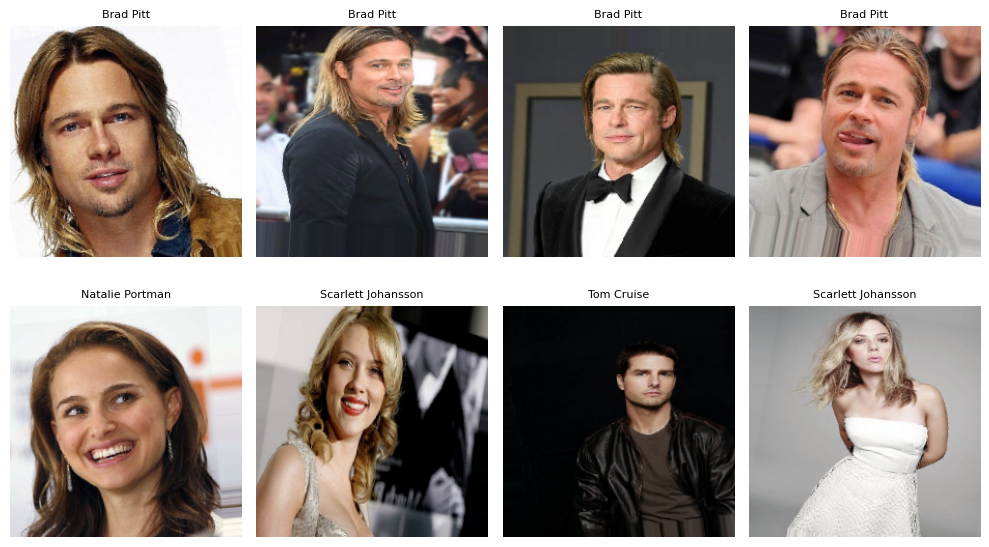

In [9]:
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i])
    plt.axis("off")
    plt.title(inv_class_indices[int(np.argmax(y_batch[i]))], fontsize=8)
plt.tight_layout()
plt.show()


## Modelo VGG16 desde Cero

Se construye manualmente una red basada en VGG16, sin usar modelos preentrenados.
La arquitectura incluye:
- Bloques Conv2D + MaxPooling
- Capas densas al final para clasificación multiclase


In [10]:
def vgg_block(x, filters, conv_layers):
    for _ in range(conv_layers):
        x = tf.keras.layers.Conv2D(filters, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2))(x)
    return x


In [11]:
inputs = tf.keras.Input(shape=(224,224,3))

# VGG16 blocks: (64x2), (128x2), (256x3), (512x3), (512x3)
x = vgg_block(inputs, 64, 2)
x = vgg_block(x, 128, 2)
x = vgg_block(x, 256, 3)
x = vgg_block(x, 512, 3)
x = vgg_block(x, 512, 3)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(classes), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │        20,48

 Total params: 134,281,029 (512.24 MB)

 Trainable params: 134,281,029 (512.24 MB)

 Non-trainable params: 0 (0.00 B)

## Parámetros del Entrenamiento y Función de Pérdida

- **Función de pérdida:** `categorical_crossentropy`  
  Se utiliza porque el problema es **multiclase** con etiquetas one-hot.

- **Optimizador:** `Adam`  
  Se selecciona por su buen rendimiento general en redes profundas.

- **Métricas:** `accuracy`  
  Permite evaluar el porcentaje de predicciones correctas.


In [12]:
LR = 1e-4

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


## Entrenamiento del Modelo

Se entrena el modelo y se monitorea la métrica de validación.
Se utiliza EarlyStopping para evitar sobreajuste.


In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1126s 74s/step - accuracy: 0.2967 - loss: 1.6027 - val_accuracy: 0.3333 - val_loss: 1.5615 - learning_rate: 1.0000e-04
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1104s 74s/step - accuracy: 0.3243 - loss: 1.5688 - val_accuracy: 0.3333 - val_loss: 1.5641 - learning_rate: 1.0000e-04
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1095s 73s/step - accuracy: 0.3271 - loss: 1.5691 - val_accuracy: 0.3333 - val_loss: 1.5552 - learning_rate: 1.0000e-04
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1092s 73s/step - accuracy: 0.3235 - loss: 1.5596 - val_accuracy: 0.3333 - val_loss: 1.5392 - learning_rate: 1.0000e-04
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1096s 73s/step - accuracy: 0.3610 - loss: 1.5128 - val_accuracy: 0.3333 - val_loss: 1.5185 - learning_rate: 1.0000e-04
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1092s 73s/step - accuracy: 0.3348 - loss: 1.5121 - val_accuracy: 0.3333 - val_loss: 1.4503 - learning_rate: 1.0000e-04
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1093s 73s/step - acc

## Resultados de Entrenamiento (Loss y Accuracy)


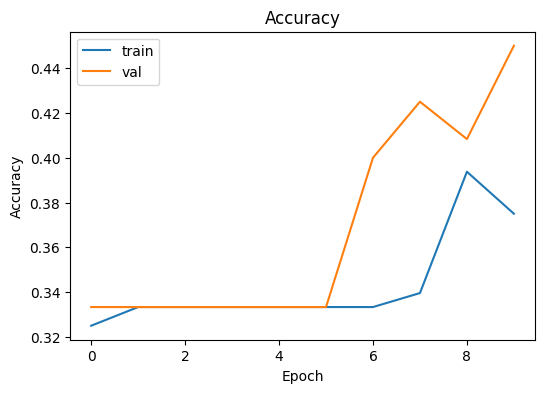

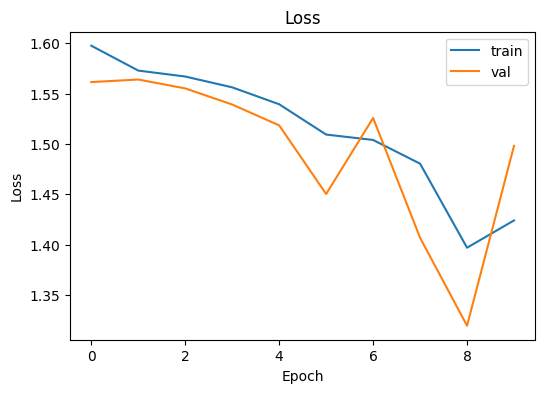

In [14]:
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train","val"])
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","val"])
plt.show()


## Matriz de Confusión (sin sklearn)

Se calcula la matriz de confusión utilizando `tf.math.confusion_matrix`
para comparar etiquetas reales vs predichas.


In [15]:
# etiquetas reales (orden de val_gen)
y_true = val_gen.classes

# predicciones
pred_probs = model.predict(val_gen)
y_pred = np.argmax(pred_probs, axis=1)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(classes)).numpy()
cm


4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 18s/step


array([[ 3, 16,  0,  1,  0],
       [ 5, 33,  0,  2,  0],
       [ 1, 17,  0,  2,  0],
       [ 0,  7,  0, 13,  0],
       [ 0,  4,  0, 16,  0]], dtype=int32)

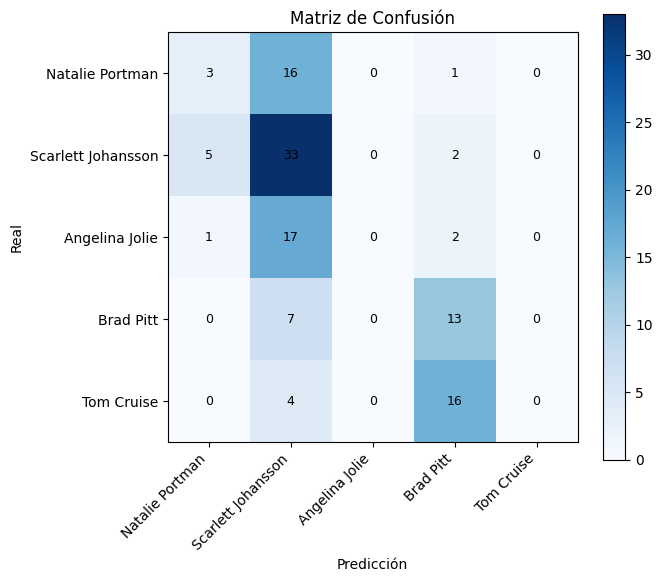

In [16]:
plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de Confusión")
plt.colorbar()
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
plt.xlabel("Predicción")
plt.ylabel("Real")

# números dentro
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=9)

plt.tight_layout()
plt.show()


## Análisis de Error

Se muestran ejemplos de imágenes mal clasificadas para analizar:
- qué clases se confunden más
- posibles causas: iluminación, ángulo, fondo, expresiones, similitud facial


Cantidad mal clasificadas: 71


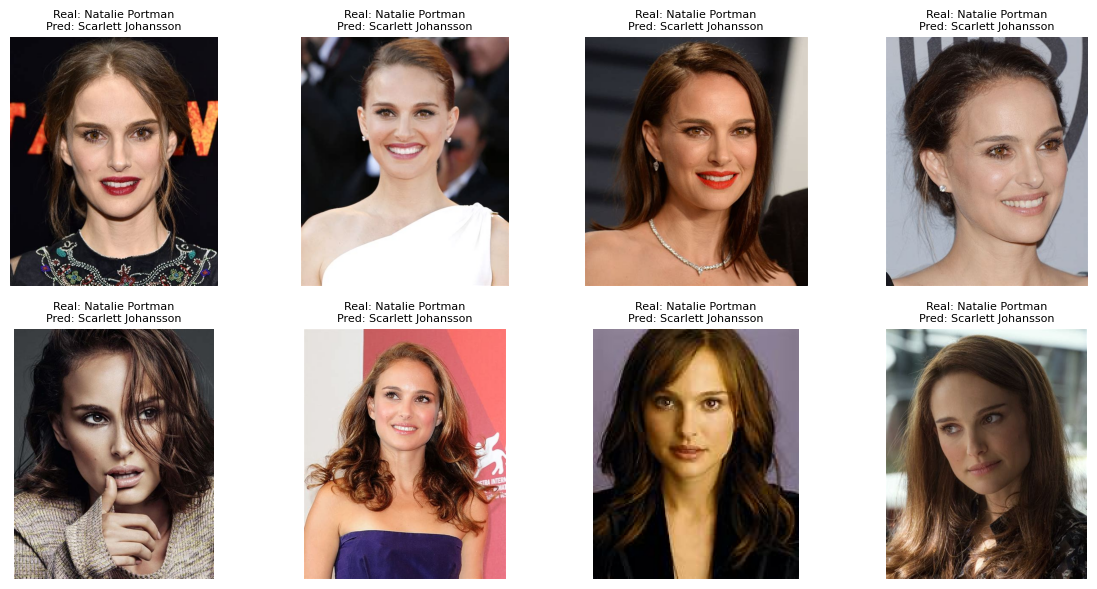

In [17]:
# obtener rutas de validación en el mismo orden que val_gen
val_files = val_gen.filenames  # lista de "Clase/archivo.jpg"
val_paths = [os.path.join(DATASET_PATH, f) for f in val_files]

wrong_idx = np.where(y_true != y_pred)[0]
print("Cantidad mal clasificadas:", len(wrong_idx))

# mostrar 8 errores
to_show = wrong_idx[:8]
plt.figure(figsize=(12,6))
for k, idx in enumerate(to_show, 1):
    img = Image.open(val_paths[idx]).convert("RGB")
    plt.subplot(2,4,k)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Real: {classes[y_true[idx]]}\nPred: {classes[y_pred[idx]]}", fontsize=8)
plt.tight_layout()
plt.show()


**Observación:**  
Los errores tienden a ocurrir entre clases con rasgos faciales similares o en imágenes con cambios fuertes de iluminación/ángulo.
Posibles mejoras:
- Aumentar número de imágenes por clase (balance)
- Incrementar data augmentation
- Ajustar learning rate y epochs
- Usar regularización adicional


## Guardado del Modelo
Se guarda el modelo entrenado para su posterior uso en la interfaz web.


In [18]:
MODEL_PATH = "/content/vgg16_multiclass_from_scratch.keras"
model.save(MODEL_PATH)
MODEL_PATH


'/content/vgg16_multiclass_from_scratch.keras'

## Interfaz Web (Gradio)

Se crea una interfaz web simple para subir una imagen y obtener la predicción
del modelo multiclase.


In [19]:
!pip -q install gradio
import gradio as gr

def predict_image(img):
    img = img.convert("RGB").resize(IMG_SIZE)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = np.expand_dims(arr, axis=0)
    probs = model.predict(arr)[0]
    return {classes[i]: float(probs[i]) for i in range(len(classes))}

demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Celebrity Face – Multiclase (VGG16 desde cero)"
)
demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d97bbeba53468fccdf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Conclusiones

Se construyó e implementó una red neuronal tipo **VGG16 desde cero** para clasificación multiclase.
Se evaluó el desempeño mediante accuracy/loss y se presentó la **matriz de confusión**.
El análisis de error permitió identificar confusiones entre clases visualmente similares,
proponiendo mejoras futuras como balance de datos y ajustes de hiperparámetros.
